In [1]:
%matplotlib inline

In [19]:
import json
import csv
import locale

import pandas as pd
import numpy as np
import matplotlib

In [3]:
import seaborn as sns
sns.set_style("whitegrid")

In [10]:
# matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)  # fits better into google docs
region_name = "Томск"
region_data_file = "tomskaia-oblast.geojson"  # from https://dtp-stat.ru/opendata/

In [5]:
def get_dtp_by_region():
    def check_region(item):
        return item["properties"]["region"] == region_name

    with open(region_data_file, "rt") as f:
        dtp = json.load(f)

    res = list(filter(check_region, dtp["features"]))
    print(f'всего ДТП в регионе "{region_name}": {len(res)}')
    return res

In [6]:
dtp_tomsk = get_dtp_by_region()

всего ДТП в регионе "Томск": 2318


In [7]:
def feature_extractor(it):
    res = {
        "id": it["properties"]["id"],
        "datetime": it["properties"]["datetime"],
        "lat": it["properties"]["point"]["lat"],
        "lon": it["properties"]["point"]["long"],
        "severity": it["properties"]["severity"],
        "address": it["properties"]["address"],
        "dead_count": it["properties"]["dead_count"],
        "injured_count": it["properties"]["injured_count"],
    }
    return res

In [8]:
df = pd.DataFrame(map(feature_extractor, dtp_tomsk))
df.datetime = df.datetime.astype(np.datetime64)
df.head()

,id,datetime,lat,lon,severity,address,dead_count,injured_count
0,2528452,2020-12-20 23:02:00,56.503054,84.958584,Легкий,"г Томск, ул Дальне-Ключевская, 25Б",0,1
1,2503256,2020-10-07 20:15:00,56.576648,85.105934,С погибшими,"г Томск, Кузовлево-Светлый, 6 км",1,0
2,2539023,2021-01-31 08:20:00,56.496890,84.968401,Легкий,"г Томск, ул Яковлева, 9",0,1
3,2539024,2021-01-30 14:30:00,56.462004,84.989151,Легкий,None,0,1
4,2539025,2021-01-29 21:36:00,56.480713,85.033740,Тяжёлый,"г Томск, ул Писемского, 8",0,1


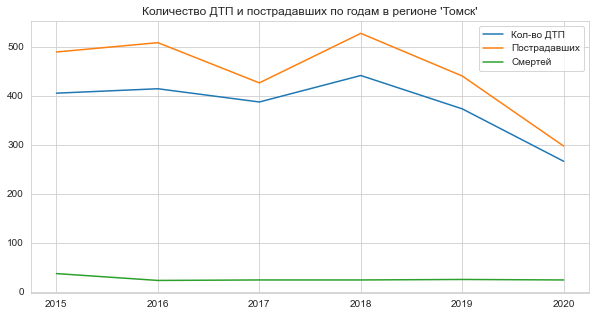

In [14]:

def plot_dtp_yearly(df_dtp):
    df_tmp = df_dtp.copy()
    
    # cut off incomplete 2021 year
    df_tmp = df_tmp[df_tmp.datetime.dt.year < 2021]
    df_tmp = df_tmp.groupby(df_tmp.datetime.dt.year).agg(
        DTP_count=("id", "size"),
        Injured_count=("injured_count", "sum"),
        Dead_count=("dead_count", "sum"),
    )

    ax = df_tmp.plot.line()
    ax.set_title(f"Количество ДТП и пострадавших по годам в регионе '{region_name}'")
    ax.set_xlabel("")

    handles, labels = ax.get_legend_handles_labels()
    label_names = {
        "DTP_count": "Кол-во ДТП", 
        "Injured_count": "Пострадавших",
        "Dead_count": "Смертей"
    }
    ax.legend(handles, [label_names[l] for l in labels])

plot_dtp_yearly(df)

In [15]:
list(df)

['id',
 'datetime',
 'lat',
 'lon',
 'severity',
 'address',
 'dead_count',
 'injured_count']

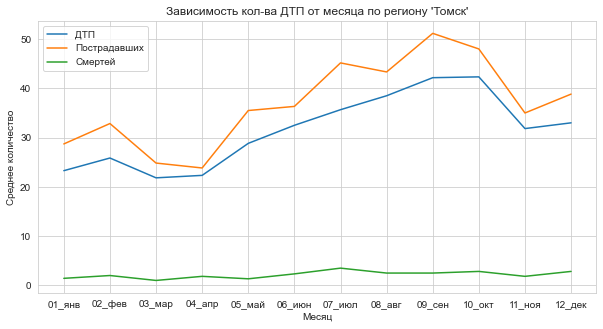

In [20]:
def plot_dtp_seasonality_by_month(df_dtp):
    df_tmp = df_dtp.copy()
    
    saved_locale = locale.setlocale(locale.LC_ALL)
    locale.setlocale(locale.LC_ALL, "ru_RU.UTF-8")
    df_tmp["year_month"] = df_tmp.datetime.map(lambda x: x.strftime('%Y_%m')) 
    df_tmp["month_n_name"] = df_tmp.datetime.map(lambda x: x.strftime('%m_%b'))
    locale.setlocale(locale.LC_ALL, saved_locale)

    # first aggregate inside every single month
    df_tmp = df_tmp.groupby(df_tmp.year_month).agg(
        DTP_count=("id", "size"),
        Injured_count=("injured_count", "sum"),
        Dead_count=("dead_count", "sum"),
        month_n_name=("month_n_name", "first"),
    )
    # second average over same month in different years
    df_tmp = df_tmp.groupby(df_tmp.month_n_name).agg(
        avg_dtp=("DTP_count", "mean"),
        avg_Injured=("Injured_count", "mean"),
        avg_Dead=("Dead_count", "mean"),
    )
    tick_labels = [i for i, x in enumerate(df_tmp.index)]
    ax = df_tmp.plot.line(xticks=tick_labels)
    ax.set_title(f"Зависимость кол-ва ДТП от месяца по региону '{region_name}'")
    ax.set_xlabel("Месяц")
    ax.set_ylabel("Среднее количество")
    
    handles, labels = ax.get_legend_handles_labels()
    label_names = {
        "avg_dtp": "ДТП", 
        "avg_Injured": "Пострадавших",
        "avg_Dead": "Смертей"
    }
    ax.legend(handles, [label_names[l] for l in labels])
#     return df_tmp

plot_dtp_seasonality_by_month(df)


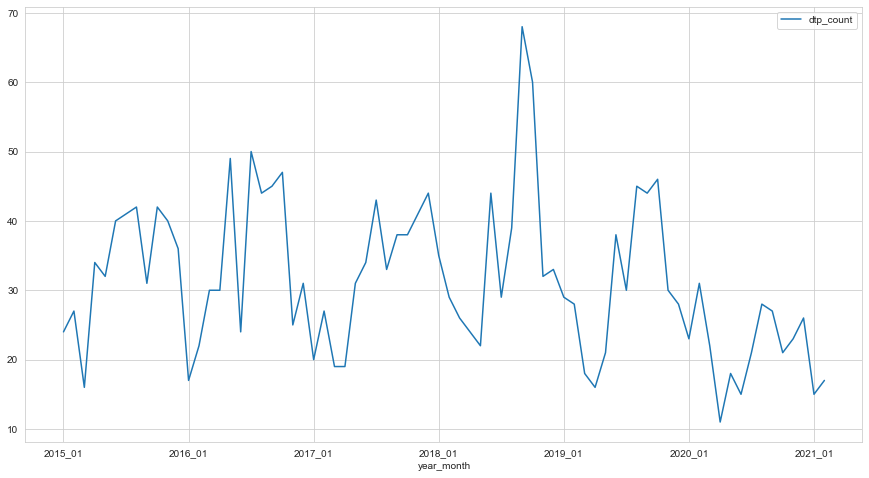

In [12]:
def plot_dtp_over_year_month(df_dtp):
    df_tmp = df_dtp.copy()
    df_tmp["year_month"] = df_tmp.datetime.map(lambda x: x.strftime('%Y_%m')) 
    
    df_tmp = df_tmp.groupby(df_tmp.year_month).agg(dtp_count=("id", "size"))
    
    labels = [i for i, x in enumerate(df_tmp.index) if x.endswith("_01")]
    
    ax = df_tmp.plot.line(xticks=labels)

plot_dtp_over_year_month(df)

In [26]:
repairs = []
with open("00_fragments.csv", "rt") as f:
    reader = csv.reader(f)
    header = next(reader)
    print("Header columns:", header)
    for row in reader:
        repairs.append(dict(zip(header,row)))
df_repairs = pd.DataFrame(repairs)
df_repairs

Header columns: ['Год работ', 'fragment_header', 'fragment_title', 'comments', 'id', 'Статус', 'Срок выполнения работ на объекте', 'Тип работ']


,Год работ,fragment_header,fragment_title,comments,id,Статус,Срок выполнения работ на объекте,Тип работ
0,2021,Ремонт,пр.Коммунистического от ул.Свердлова до ул.Лео...,,e8809a70-2216-4bee-922b-154d73ae493f,Запланирован,25.04.2021 ‒ 01.09.2021,Ремонт
1,2017,Ремонт покрытия проезжей части,Автодорога «ул.Кирова»,,70ee27cb-ab73-4efb-bcc2-93c0b5a4b85c,Завершен,01.06.2017 ‒ 31.07.2017,Ремонт покрытия проезжей части
2,2020,Ремонт,ул.Крупской: от просп.Коммунистического до ул....,,4a52c0b2-7805-4bf1-b9b7-d090263c28de,Завершен,25.04.2020 ‒ 31.08.2020,Ремонт
3,2018,Ремонт покрытия проезжей части,ул. Войкова,,56402bec-90dc-4184-bbda-07e4a7191180,Завершен,01.05.2018 ‒ 01.09.2018,Ремонт покрытия проезжей части
4,2018,Ремонт покрытия проезжей части,ул. Набережная р. Ушайки,,25d81872-36a6-4066-8132-58f14f969e50,Завершен,01.05.2018 ‒ 01.09.2018,Ремонт покрытия проезжей части
...,...,...,...,...,...,...,...,...
161,2019,Ремонт,автодорога по просп.Коммунистическому-кольцо н...,,19d7af5a-54eb-4169-b208-4e836da75c64,Завершен,10.05.2019 ‒ 30.08.2019,Ремонт
162,2019,Ремонт,ул. Смирнова от ул.Смирнова 1 до ул.Кольцевой ...,,8d86833b-14c7-47a6-9522-9f640bbce034,Завершен,15.05.2019 ‒ 08.10.2019,Ремонт
163,2017,Ремонт покрытия проезжей части,ул. 1-ая Ново-Деповская,,60cee825-414b-4c52-b632-eb863e351243,Завершен,18.04.2017 ‒ 31.08.2017,Ремонт покрытия проезжей части
164,2017,Ремонт покрытия проезжей части,Чекистский тракт,,c1604843-8c3a-46f6-a7e0-6d6ff5841a68,Завершен,18.04.2017 ‒ 05.10.2017,Ремонт покрытия проезжей части


In [31]:
def group_by_year_severity(df_dtp):
    df_tmp = df_dtp.copy()
    df_tmp.severity = df_tmp.severity.astype("category")
    df_tmp.severity.cat.set_categories(["Легкий", "Тяжёлый", "С погибшими"], inplace=True)  # sorting order
    df_tmp["year"] = df_tmp.datetime.dt.year
    return df_tmp.groupby(["year", "severity"]).agg(count=("id", "size"))

group_by_year_severity(df)  #.unstack()

count
year severity          
2015 Легкий         103
     Тяжёлый        271
     С погибшими     31
2016 Легкий         160
     Тяжёлый        233
     С погибшими     21
2017 Легкий         202
     Тяжёлый        162
     С погибшими     23
2018 Легкий         218
     Тяжёлый        202
     С погибшими     21
2019 Легкий         165
     Тяжёлый        183
     С погибшими     25
2020 Легкий          99
     Тяжёлый        145
     С погибшими     22
2021 Легкий          18
     Тяжёлый         12
     С погибшими      2